# Predicting the *SiteEnergyUse(kBtu)* with supervised machine learning algorithms

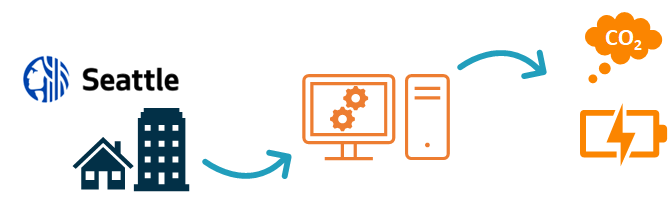

After de EDA and cleaning of the dataset, the data are almost ready to be fed to a machine learning algorithm. In order to improve the model performances, the features can be reprocessed. As an example, numerical features can me rescaled. Another common method is the encoding of categorical features.

In this document, the data previously cleaned have been imported. Then a naive model has been employed for predicting the target *SiteEnergyUse(kBtu)*. Then, the performances brought by several methods of data preprocessing have been assessed.

Then, the performances of several machine learning models have been assessed with the appropriate metrics.

Finally, the prediction resulting from the higher-performing model has been studied in detail.

**Importing libraries and custom colors**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\envs\Project_3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_union
from sklearn.compose import make_column_transformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [3]:
# Create a log transformer for converting data to log
LogTransformer = FunctionTransformer(func = np.log1p, feature_names_out = 'one-to-one')


# Create custom encoder for categorical data
def none_cat_encoder(df):
    df[df == 'None'] = 0
    df[df != 0] = 1
    return df

custom_cat_encoder = FunctionTransformer(none_cat_encoder,
                                         feature_names_out = 'one-to-one')

In [4]:
# Custom colors for charts

c_0 = np.array([2, 48, 71,256])/256
c_1 = np.array([251, 133, 0,256])/256
c_2 = np.array([255, 183, 3,256])/256
c_3 = np.array([33, 158, 188,256])/256
c_4 = np.array([142, 202, 230,256])/256

# Creating a custom colormap
# The code comes from https://matplotlib.org/3.1.1/tutorials/colors/colormap-manipulation.html
from matplotlib.colors import ListedColormap

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(c_0[0], c_1[0], N)
vals[:, 1] = np.linspace(c_0[1], c_1[1], N)
vals[:, 2] = np.linspace(c_0[2], c_1[2], N)
custom_cmp1 = ListedColormap(vals)

# A colormap with white in the middle
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.concatenate((np.linspace(c_0[0], 1, 128), np.linspace(1, c_1[0], 128)), axis = None)
vals[:, 1] = np.concatenate((np.linspace(c_0[1], 1, 128), np.linspace(1, c_1[1], 128)), axis = None)
vals[:, 2] = np.concatenate((np.linspace(c_0[2], 1, 128), np.linspace(1, c_1[2], 128)), axis = None)
custom_cmp2 = ListedColormap(vals)

**The data are imported**

In [5]:
# Importing the data
df = pd.read_csv('cleaned_df.csv')
df.head()

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,...,ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,distance(km),streetType,ElectricityProp,NaturalGasProp,SteamProp,OtherEnergyProp,Imp_NumberofFloors
0,NonResidential,Hotel,DOWNTOWN,1927,1.0,0,88434,Hotel,None,0.0,...,60.0,7226362.5,249.98,0.512422,way,0.546060,0.176638,0.277302,6.919110e-08,12
1,NonResidential,Hotel,DOWNTOWN,1996,1.0,15064,88502,Hotel,Parking,15064.0,...,61.0,8387933.0,295.86,0.624190,street,0.386609,0.613391,0.000000,0.000000e+00,11
2,NonResidential,Hotel,DOWNTOWN,1969,1.0,196718,759392,Hotel,None,0.0,...,43.0,72587024.0,2089.28,0.701359,avenue,0.682307,0.020579,0.297113,8.265940e-08,41
3,NonResidential,Hotel,DOWNTOWN,1926,1.0,0,61320,Hotel,None,0.0,...,56.0,6794584.0,286.43,0.708090,street,0.407519,0.266567,0.325913,1.103820e-07,10
4,NonResidential,Hotel,DOWNTOWN,1980,1.0,62000,113580,Hotel,Parking,68009.0,...,75.0,14172606.0,505.01,0.740453,street,0.378802,0.621198,0.000000,7.055865e-08,18


# 1. Data preprocessing

## 1.1 Evaluation with a naive model

Once imported, a naive model on numerical data is built to identify problems of under- and overfitting

In [6]:
# First naive model


# Raw data
x = df.select_dtypes(include = [float, int]).drop(['TotalGHGEmissions', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)'], axis = 1)
y = df['SiteEnergyUse(kBtu)']

# Train and test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

# Scaling
scaler = StandardScaler().fit(x_train)

x_train_sc = scaler.transform(x_train)

x_test_sc = scaler.transform(x_test)

<AxesSubplot:>

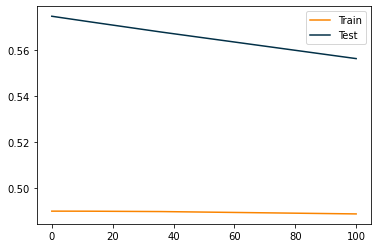

In [7]:
# Building and trainning the model (without cross-validation for estimation of weights)

test_score = []
train_score = []
weights = []


for alpha in np.logspace(-2, 2, 10):
    model = Ridge(alpha = alpha)
    model.fit(x_train_sc, y_train)
    
    train_score.append(model.score(x_train_sc, y_train))
    test_score.append(model.score(x_test_sc, y_test))
    weights.append(model.coef_)


sns.lineplot(x = np.logspace(-2, 2, 10), y = train_score, color = c_1, label = 'Train')
sns.lineplot(x = np.logspace(-2, 2, 10), y = test_score, color = c_0, label = 'Test')

The model offers poor performances:

- The difference between the test and train set show overfitting
- Data like PropertyGFABuildings have extreme weigts when compared to other parameters

## 1.2 Data preprocessing

In order to better understand the data, various models are fitted to the data and different methods of feature engineering are assessed

In [8]:
def model_eval(transformer, model, cv_params, x_train, x_test, y_train, y_test): # Function to evaluate a given model
    # The model is put in a pipepline
    pipe = make_pipeline(transformer, model)
    # The model is evaluated and optimised through cross validation
    pipe_cv = GridSearchCV(pipe, cv_params, cv = 5)

    pipe_cv.fit(x_train, y_train)
    
    y_train_pred = pipe_cv.predict(x_train)
    y_test_pred = pipe_cv.predict(x_test)
    
    # Results are put in a table and displayed
    results = [
        ('R²', r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)),
        ('MSE', mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)),
        ('RMSE', mean_squared_error(y_train, y_train_pred, squared = False), mean_squared_error(y_test, y_test_pred, squared = False)),
        ('MAE', mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred))
    ]
    
    print('{:<5} {:<20} {:<20}'.format(' ','Train','Test'))
    
    for line in results:
        print(f'{line[0]:<5}{line[1]:<20.3}{line[2]:<20.3}')
    

    return pipe_cv
    

### 1.2.1 Log conversion

First, the conversion of features to log is assessed
For the sake of simplicity, a function is created for model evaluation

In [9]:
# Features that could be log according to the EDA
log_list = ['NumberofBuildings',
'NumberofFloors',
'PropertyGFATotal',
'PropertyGFAParking',
'PropertyGFABuilding(s)',
'LargestPropertyUseTypeGFA',
'SecondLargestPropertyUseTypeGFA',
'ThirdLargestPropertyUseTypeGFA',
'SiteEUI(kBtu/sf)',
'SiteEUIWN(kBtu/sf)',
'SourceEUI(kBtu/sf)',
'SourceEUIWN(kBtu/sf)',
'SiteEnergyUse(kBtu)',
'SiteEnergyUseWN(kBtu)',
'SteamUse(kBtu)',
'Electricity(kWh)',
'Electricity(kBtu)',
'NaturalGas(therms)',
'NaturalGas(kBtu)',
'TotalGHGEmissions',
'GHGEmissionsIntensity',
'Imp_NumberofFloors']

The features are converted to log through the transformer.

The target is also converted to log and standardised beforehand.

In [10]:
x = df[['PropertyGFABuilding(s)', 'Imp_NumberofFloors']]
y = df['SiteEnergyUse(kBtu)']

# Train and test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

# Target preprocessing

t_scaler = StandardScaler().fit(np.log1p(y_train.values.reshape(-1,1)))

y_train = t_scaler.transform(np.log1p(y_train).values.reshape(-1,1))
y_test = t_scaler.transform(np.log1p(y_test).values.reshape(-1,1))

# Features preprocessing

transformer = make_pipeline(LogTransformer, StandardScaler()) # LogTransformer was defined earlier and convert to ln

model = Ridge()

params_cv = {'ridge__alpha' : np.logspace(-2, 3, 10)}


model = model_eval(scaler, Ridge(), params_cv, x_train, x_test, y_train, y_test)

      Train                Test                
R²   0.352               0.368               
MSE  0.648               0.529               
RMSE 0.805               0.728               
MAE  0.621               0.574               


The target is represented before and after processing

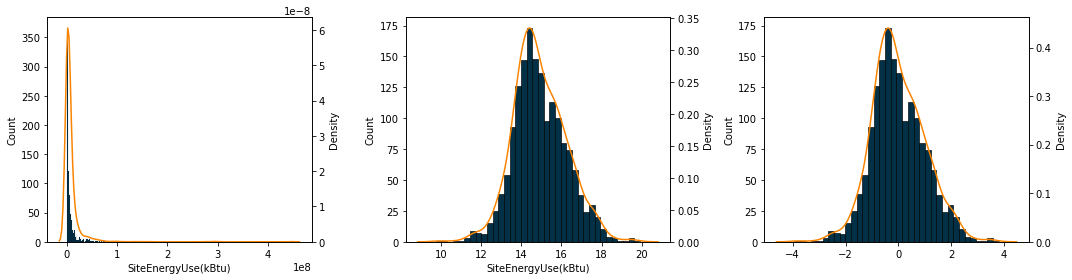

In [11]:
fig = plt.figure(figsize = (15, 4))

ax1 = fig.add_subplot(131)
sns.histplot(y, color = c_0, alpha = 1, ax = ax1)
ax2 = plt.twinx()
sns.kdeplot(y, color = c_1, ax = ax2)

ax3 = fig.add_subplot(132)
sns.histplot(np.log1p(y), color = c_0, alpha = 1, ax = ax3)
ax4 = plt.twinx()
sns.kdeplot(np.log1p(y), color = c_1, ax = ax4)

ax5 = fig.add_subplot(133)
sns.histplot(StandardScaler().fit_transform(np.log1p(y.values.reshape(-1,1))).reshape(-1,), color = c_0, alpha = 1, ax = ax5)
ax6 = plt.twinx()
sns.kdeplot(StandardScaler().fit_transform(np.log1p(y.values.reshape(-1,1))).reshape(-1,), color = c_1, ax = ax6)

plt.tight_layout()

This time the model is slightly underfitting but poor performances are obtained.

### 1.2.2 Encoding categories

For the model to be able to process categorical features, the features should be encoded numericaly.

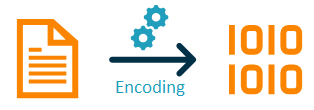

Two methods of encoding have been assessed. The first method replace non-null values by 1 and empty values by 0, indicating the presence or not of a categorical feature for the sample. The second method is OneHot encoding (OHE). OHE is generaly preferend for features with n_features <= 15.

Categories with a large number of unique labels or with to much empty values have more chances to have labels representing a low proportion of individuals and could raise errors as labels in the test set could have more chance to not be represented in the train set. This is the case for *SecondLargestPropertyUseType* ans *ThirdLargestPropertyUseType* that must be encoded through the custom encoding strategy.

In order to estimate which feature should be encoded with OHE and which should be encoded with the custom strategy, models have been fed with features encoded differently depending on the number of unique value they contain. As explained earlier, a feature with a low number of unique values have better chances to be better represented with OHE and vice versa.

Models have been fed with data that have been encoded differently depending on a threshold. Features with a number of unique values under the threshold have been encoded with the OHE. The other features have been encoded with the custom method. All numerical have also been added.

The threshold has then been moved and the performance of each model has been assessed with relevant metrics.

In [12]:
'''
x and y preprocessing
'''

x = df.drop(['TotalGHGEmissions', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)'], axis = 1)
y = df['SiteEnergyUse(kBtu)']

# Train and test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)



# Target preprocessing

t_scaler = StandardScaler().fit(np.log1p(y_train.values.reshape(-1,1)))

y_train = t_scaler.transform(np.log1p(y_train).values.reshape(-1,1))
y_test = t_scaler.transform(np.log1p(y_test).values.reshape(-1,1))


# Features preprocessing

# split categorical and numerical columns

col_cat = x.select_dtypes(exclude = [float, int]).columns

col_num = x.select_dtypes(include = [float, int]).columns

# Numerical features preprocessing
# split log and non-log numerical data

col_log_num = [col for col in col_num if col in log_list]

col_nonLog_num = [col for col in col_num if col not in log_list]

pipe_log = make_pipeline(LogTransformer, StandardScaler()) # Creating a pipepline to both transform to log and scale numerical data





r_quared_train = [] # The score obtained on the test and train set are recorded to draw curves latter
r_quared_test = [] 

# Categorical feature preprocessing
# split cat depending on the number of unique labels per cat

for cat_threshold in [4, 6, 15, 23, 41, 49, 56]: # Under this threshold, HOE is performed

    print(f'Threshlod = {cat_threshold}')
    
    col_cat_HOE = [col for col in col_cat if df[col].nunique() <= cat_threshold]


    col_custom_cat_encoder = ['LargestPropertyUseType', 'SecondLargestPropertyUseType','ThirdLargestPropertyUseType']




    # Combining the preprocessing transformers

    transformer = make_column_transformer((pipe_log, col_log_num),
                                          (StandardScaler(), col_nonLog_num),
                                          (OneHotEncoder(handle_unknown = 'ignore'), col_cat_HOE),
                                          (custom_cat_encoder, col_custom_cat_encoder)) # Ordinal encoded data have been removed





    model = Ridge()

    params_cv = {'ridge__alpha' : np.logspace(-2, 3, 10)}


    model = model_eval(transformer, Ridge(), params_cv, x_train, x_test, y_train, y_test)
    
    r_quared_test.append(model.score(x_test, y_test))
    r_quared_train.append(model.score(x_train, y_train))

Threshlod = 4
      Train                Test                
R²   0.634               0.616               
MSE  0.366               0.322               
RMSE 0.605               0.567               
MAE  0.445               0.415               
Threshlod = 6
      Train                Test                
R²   0.638               0.622               
MSE  0.362               0.317               
RMSE 0.602               0.563               
MAE  0.441               0.412               
Threshlod = 15
      Train                Test                
R²   0.65                0.624               
MSE  0.35                0.315               
RMSE 0.592               0.561               
MAE  0.434               0.407               
Threshlod = 23
      Train                Test                
R²   0.75                0.729               
MSE  0.25                0.227               
RMSE 0.5                 0.477               
MAE  0.356               0.35                
Threshlod = 41

The performances of the models depending on the threshold have been represented graphicaly:

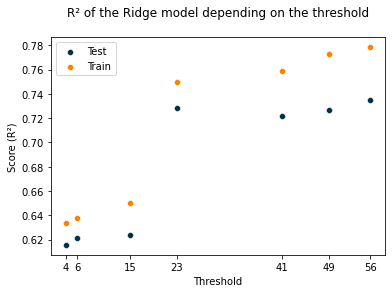

In [13]:
# The curves of the score depending on the threshold can be displayed
fig, ax = plt.subplots()

sns.scatterplot(x = [4, 6, 15, 23, 41, 49, 56], y = r_quared_test, label = 'Test', color = c_0, ax = ax)
sns.scatterplot(x = [4, 6, 15, 23, 41, 49, 56], y = r_quared_train, label = 'Train', color = c_1, ax = ax)

ax.set_xlabel('Threshold')
ax.set_ylabel('Score (R²)')
ax.set_xticks([4, 6, 15, 23, 41, 49, 56])

ax.set_title('R² of the Ridge model depending on the threshold\n')

plt.show()

In [14]:
df[col_cat].nunique()

BuildingType                     5
PrimaryPropertyType             22
Neighborhood                    14
LargestPropertyUseType          55
SecondLargestPropertyUseType    48
ThirdLargestPropertyUseType     40
streetType                       5
dtype: int64

The model shows this time way better performances with low to no overfitting and no traces of underfitting

The performances show improved performances until an threshold of 23 (meaning including *PrimaryPropertyType* in the HOE encoding). Higher thresholds do not significantly improves the model performances.

### 1.2.3 Polynomial features

As certain relationships could be non linear, the influence en adding polynomial features of various degrees is observed

In [15]:
'''
x and y preprocessing
'''

x = df.drop(['TotalGHGEmissions', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)'], axis = 1)
y = df['SiteEnergyUse(kBtu)']

# Train and test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)


# Target preprocessing

t_scaler = StandardScaler().fit(np.log1p(y_train.values.reshape(-1,1)))

y_train_trans = t_scaler.transform(np.log1p(y_train).values.reshape(-1,1))
y_test_trans = t_scaler.transform(np.log1p(y_test).values.reshape(-1,1))


# split categorical and numerical columns

col_cat = x.select_dtypes(exclude = [float, int]).columns

col_num = x.select_dtypes(include = [float, int]).columns

# Numerical features preprocessing
# split log and non-log numerical data

col_log_num = [col for col in col_num if col in log_list]

col_nonLog_num = [col for col in col_num if col not in log_list]

pipe_log = make_pipeline(LogTransformer, PolynomialFeatures(), StandardScaler()) # Creating a pipepline to both transform to log, add polynomial features and scale numerical data

pipe_nonLog = make_pipeline(PolynomialFeatures(), StandardScaler()) # Creating a pipepline to both add polynomial features and scale numerical data



# Categorical feature preprocessing
# split cat depending on the number of unique labels per cat

cat_threshold = 25
    
col_cat_HOE = [col for col in col_cat if df[col].nunique() <= cat_threshold]


col_custom_cat_encoder = ['LargestPropertyUseType', 'SecondLargestPropertyUseType','ThirdLargestPropertyUseType']




# Combining the preprocessing transformers

transformer = make_column_transformer((pipe_log, col_log_num),
                                    (pipe_nonLog, col_nonLog_num),
                                    (OneHotEncoder(handle_unknown = 'ignore'), col_cat_HOE))





model = Ridge()

params_cv = {'columntransformer__pipeline-2__polynomialfeatures__degree' : [1, 2, 3, 4],
             'columntransformer__pipeline-1__polynomialfeatures__degree' : [1, 2, 3, 4],
             'ridge__alpha' : np.logspace(-3, -2, 1, 3)}


model = model_eval(transformer, Ridge(), params_cv, x_train, x_test, y_train_trans, y_test_trans)

      Train                Test                
R²   0.769               0.73                
MSE  0.231               0.227               
RMSE 0.481               0.476               
MAE  0.345               0.352               


In [16]:
model.best_params_

{'columntransformer__pipeline-1__polynomialfeatures__degree': 2,
 'columntransformer__pipeline-2__polynomialfeatures__degree': 2,
 'ridge__alpha': 0.001}

There is not a large improvement of the model performances with polynomial features, thus they can be withdrawn form the procedure.

Then, the weight of the different features are looked closely.

<AxesSubplot:>

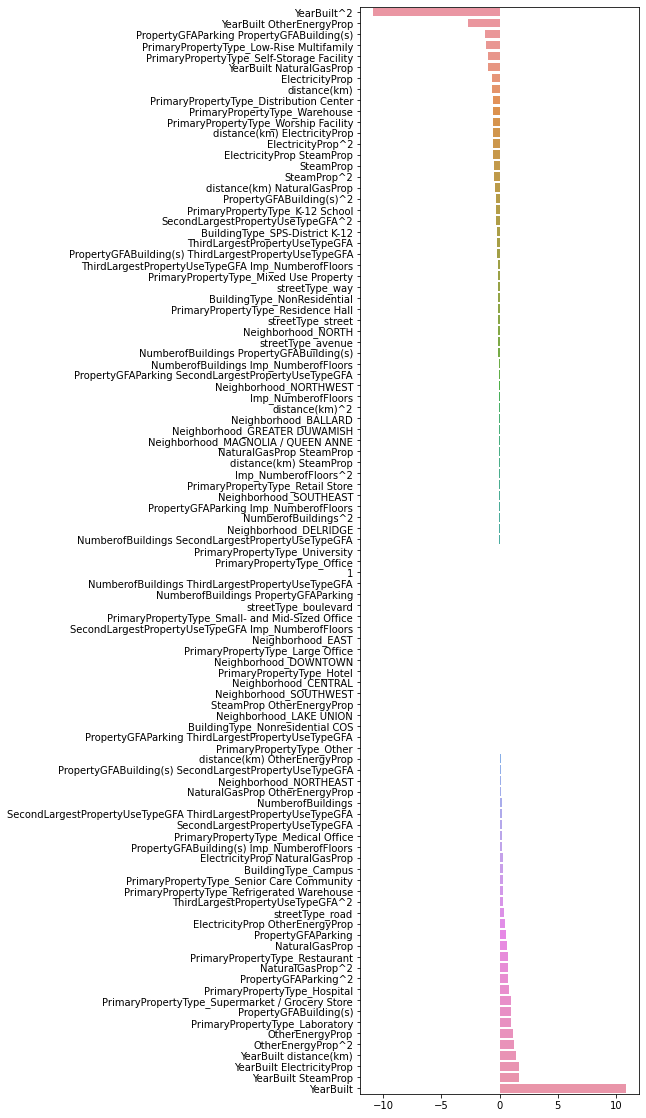

In [17]:
# Getting the name of all parameters through the pipeline
features_names = np.concatenate((model.best_estimator_.steps[0][1].transformers_[0][1].get_feature_names_out(col_log_num),
                            model.best_estimator_.steps[0][1].transformers_[1][1].get_feature_names_out(col_nonLog_num),
                            model.best_estimator_.steps[0][1].transformers_[2][1].get_feature_names_out(col_cat_HOE)),
                            axis = None)


features_weights = model.best_estimator_['ridge'].coef_[0]

# Sort the weights with their corresponding label
arg_wheigt = features_weights.argsort()
features_weights = features_weights[arg_wheigt]
features_names = features_names[arg_wheigt]

fig, ax = plt.subplots(figsize = (5,20))

sns.barplot(x = features_weights,
            y = features_names)


From features weights analysis is can be observed that :

- Have a low influence
    - Neighborhood
    - streetType
    - LargetPropertyUseType
    - SecondLargestPropertyUseType
    - ThirdLargestPropertyUseType
    

- Have a mild (-) influence
    - Number of building
    - Number of floors
    

- Have a mild (+) influence
    - BuildingType
    - PrimaryPropertyType
    - distance(km)
    - PropertyGFABuilding(s)
    - PropertyGFAParking
    
    
- Have a strong influence
    - Energy proportion
    - Year Build

For the sake of readability, the data preprocessing is resumed in a function.

The performances of the model through this function employing only features with important and mild weigths are assesed

In [18]:
def preprocessing(target):
    x = df.drop(['TotalGHGEmissions',
                 'ENERGYSTARScore',
                 'SiteEnergyUse(kBtu)',
                 'Neighborhood',
                 'streetType',
                 'LargestPropertyUseType',
                 'SecondLargestPropertyUseType',
                 'ThirdLargestPropertyUseType',
                 'NumberofBuildings',
                 'Imp_NumberofFloors'], axis = 1)

    y = df[target]

    # Train and test split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)
    
    # Target preprocessing

    t_scaler = StandardScaler().fit(np.log1p(y_train.values.reshape(-1,1)))

    y_train = t_scaler.transform(np.log1p(y_train).values.reshape(-1,1)).reshape(-1,)
    y_test = t_scaler.transform(np.log1p(y_test).values.reshape(-1,1)).reshape(-1,)
    
    

    # split categorical and numerical columns

    col_cat = x.select_dtypes(exclude = [float, int]).columns

    col_num = x.select_dtypes(include = [float, int]).columns

    # Numerical features preprocessing
    # split log and non-log numerical data

    col_log_num = [col for col in col_num if col in log_list]

    col_nonLog_num = [col for col in col_num if col not in log_list]

    pipe_log = make_pipeline(LogTransformer, StandardScaler()) # Creating a pipepline to both transform to log, add polynomial features and scale numerical data

    pipe_nonLog = make_pipeline(StandardScaler()) # Creating a pipepline to both add polynomial features and scale numerical data



    # Categorical feature preprocessing
    # split cat depending on the number of unique labels per cat

    cat_threshold = 25

    col_cat_HOE = [col for col in col_cat if df[col].nunique() <= cat_threshold]







    # Combining the preprocessing transformers

    transformer = make_column_transformer((pipe_log, col_log_num),
                                        (pipe_nonLog, col_nonLog_num),
                                        (OneHotEncoder(handle_unknown = 'ignore'), col_cat_HOE))
    
    return x_train, x_test, y_train, y_test, transformer, t_scaler

In [19]:
'''
x and y preprocessing
'''
for target in ['SiteEnergyUse(kBtu)']:
    print('Target : ', target) 
    
    model = Ridge()

    params_cv = {'ridge__alpha' : np.logspace(-3, 2, 10)}

    
    x_train, x_test, y_train, y_test, transformer, t_scaler = preprocessing(target)
    
    model = model_eval(transformer, Ridge(), params_cv, x_train, x_test, y_train, y_test)

Target :  SiteEnergyUse(kBtu)
      Train                Test                
R²   0.748               0.722               
MSE  0.252               0.233               
RMSE 0.502               0.483               
MAE  0.353               0.359               


# 2. Model selection 

Now that features have been selected and engineered, several machine learning models have been applied, fed with the data, optimized with cross-validation and assessed with the relevant metrics.

## 2.1 Assessment of a list of models

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import learning_curve






model_list = [[LinearRegression(), {}],
              [Ridge(), {'ridge__alpha' : np.logspace(-3,2,10)}],
              [Lasso(max_iter = 2000, tol = 0.001), {'lasso__alpha' : np.logspace(-3,2,10)}],
              [SVR(), {'svr__C' : np.logspace(-3,0,10), 'svr__kernel' : ['linear', 'poly', 'rbf', 'sigmoid']}],
              [DecisionTreeRegressor(), {'decisiontreeregressor__min_samples_leaf' : [1, 10, 100]}],
              [RandomForestRegressor(), {'randomforestregressor__min_samples_leaf' : [1, 10, 100]}],
              [XGBRegressor(), {}]]

model_dict = {}

for target in ['SiteEnergyUse(kBtu)']:
    print('Target : ', target)
    
    # Data Preprocessing
    x_train, x_test, y_train, y_test, transformer, t_scaler = preprocessing(target)
    

    for model_and_params in model_list:
        print('Model : ', model_and_params[0])

        model = model_and_params[0]

        params_cv = model_and_params[1]
        
        # The new model is added to the dict for further evaluation
        model_dict[str(model_and_params[0])] = model_eval(transformer, model, params_cv, x_train, x_test, y_train, y_test)


C:\ProgramData\Anaconda3\envs\Project_3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Target :  SiteEnergyUse(kBtu)
Model :  LinearRegression()
      Train                Test                
R²   0.75                0.72                
MSE  0.25                0.234               
RMSE 0.5                 0.484               
MAE  0.351               0.359               
Model :  Ridge()
      Train                Test                
R²   0.748               0.722               
MSE  0.252               0.233               
RMSE 0.502               0.483               
MAE  0.353               0.359               
Model :  Lasso(max_iter=2000, tol=0.001)
      Train                Test                
R²   0.748               0.722               
MSE  0.252               0.233               
RMSE 0.502               0.482               
MAE  0.353               0.358               
Model :  SVR()
      Train                Test                
R²   0.742               0.718               
MSE  0.258               0.237               
RMSE 0.508               0.487   

For the target *SiteEnergyUse(kBtu)*

- The higher score without traces of overfitting is the ridge.
- The higher score but with clear overfitting is the RandomForestRegressor and XGBRegressor.

## 2.2 RandomForestRegressor

In [22]:
# Data Preprocessing
x_train, x_test, y_train, y_test, transformer, t_scaler = preprocessing('SiteEnergyUse(kBtu)')

model = RandomForestRegressor(n_estimators = 500, max_depth = 10)

params_cv = {'randomforestregressor__max_features': [0.3, 0.4, 0.6]}


model = model_eval(transformer, model, params_cv, x_train, x_test, y_train, y_test)

      Train                Test                
R²   0.916               0.771               
MSE  0.0845              0.192               
RMSE 0.291               0.438               
MAE  0.215               0.329               


In [23]:
model.best_params_

{'randomforestregressor__max_features': 0.6}

After optimisation on *SiteEnergyUse(kBtu)*, the model is improved but still overfitting

## 2.3 XGboost

In [24]:
model = XGBRegressor(booster='gbtree',max_depth = 2)

params_cv = {'xgbregressor__eta' : [0.1, 0.2, 0.3],
             'xgbregressor__subsample' : [0.5, 0.6, 0.75]}


model = model_eval(transformer, model, params_cv, x_train, x_test, y_train, y_test)

      Train                Test                
R²   0.877               0.783               
MSE  0.123               0.182               
RMSE 0.35                0.426               
MAE  0.264               0.334               


In [25]:
model.best_params_

{'xgbregressor__eta': 0.2, 'xgbregressor__subsample': 0.6}

After optimisation on *SiteEnergyUse(kBtu)*, the model shows improved performances with still a part of overfitting (but milder than in the case of the random forest)

The Ridge model shows good performances but with traces of overfitting

# 3. Model evaluation

The capacity of the model to generalise and give accurate predictions is assesed from various metrics.

The model selected is the XGBRegressor(booster='gbtree', eta = 0.2, max_depth = 2, subsample = 0.6)

The model have been trained? Then a graph representing the **R²** as well as the **model predictions versus the true values** for the test and train set have been displayed.

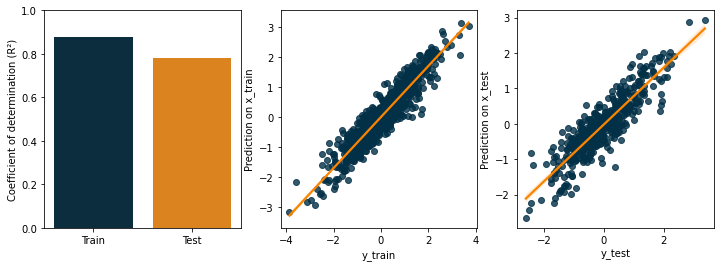

In [29]:
# Data Preprocessing
x_train, x_test, y_train, y_test, transformer, t_scaler = preprocessing('SiteEnergyUse(kBtu)')

model = XGBRegressor(booster='gbtree', eta = 0.2, max_depth = 2, subsample = 0.6)
pipe = make_pipeline(transformer, model)
pipe.fit(x_train, y_train)


# For the sake of simplicity, the procedure is stored in a function

def evaluate_log_target(pipe, x_train, x_test, y_train, y_test):
    # First the model is again evaluated on the train and test set (in log)
    y_train_pred = pipe.predict(x_train)
    y_test_pred = pipe.predict(x_test)

    prediction = [] # Store predicted y to compare with original y

    r2 = [] # Store coef of determination
    mse = [] # Store mean squared error
    rmse= [] # Store Root mean squared error
    mae = [] # Store mean average error

    for x, y in [(x_train, y_train), (x_test, y_test)]:
        y_pred = pipe.predict(x)
        prediction.append(y_pred)

        r2.append(r2_score(y, y_pred))
        mse.append(mean_squared_error(y, y_pred))
        rmse.append(mean_squared_error(y, y_pred, squared = False))
        mae.append(mean_absolute_error(y, y_pred))


    fig = plt.figure(figsize = (12,4))

    ax1 = fig.add_subplot(1,3,1)
    sns.barplot(x = ['Train', 'Test'], y = r2, ax = ax1, palette = [c_0, c_1])
    ax1.set_ylim(0,1)
    ax1.set_ylabel('Coefficient of determination (R²)')

    ax2 = fig.add_subplot(1,3,2)
    sns.regplot(x = y_train, y = prediction[0], ax = ax2, color = c_0, line_kws = {'color' : c_1})
    ax2.set_ylabel('Prediction on x_train')
    ax2.set_xlabel('y_train')

    ax3 = fig.add_subplot(1,3,3)
    sns.regplot(x = y_test, y = prediction[1], ax = ax3, color = c_0, line_kws = {'color' : c_1})
    ax3.set_ylabel('Prediction on x_test')
    ax3.set_xlabel('y_test')
    
    return r2, mse, rmse, mae

r2, mse, rmse, mae = evaluate_log_target(pipe, x_train, x_test, y_train, y_test)

The results obtained corresponds to predictions of scaled values. However, the predicted values can be transformed in their original unit for a better clarity. The metrics (R², MSE, RMSE and MAE) have been calculated and displayed graphically for the model predictions in the original units.

The prediction versus true values for the test and train set have been displayed as well.

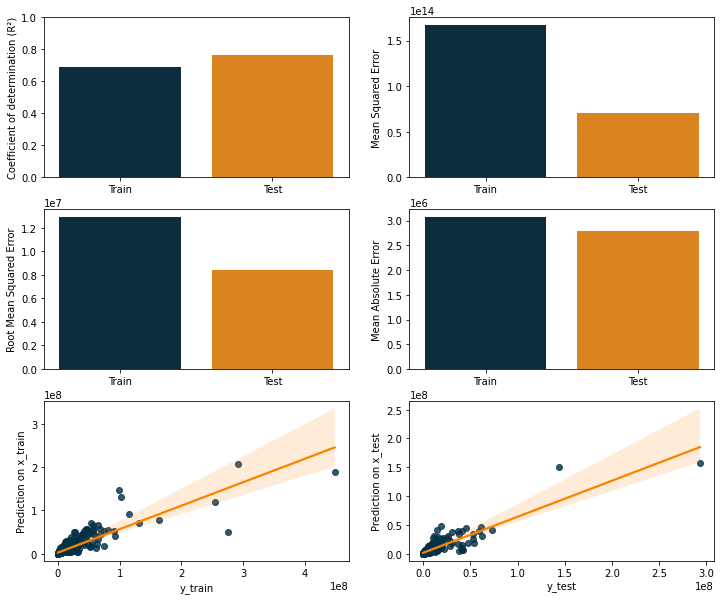

In [30]:
# Secondly the model is evaluated this time on the targets in their original unit


# For the sake of simplicity, the procedure is stored in a function

def evaluate_target(pipe, x_train, x_test, y_train, y_test):
    # The inverse of the StandardScaler and Log1p transformation is applied to the targets
    y_train_pred = np.expm1(t_scaler.inverse_transform(pipe.predict(x_train).reshape(-1,1)))
    y_test_pred = np.expm1(t_scaler.inverse_transform(pipe.predict(x_test).reshape(-1,1)))

    y_train_inv = np.expm1(t_scaler.inverse_transform(y_train.reshape(-1,1)))
    y_test_inv = np.expm1(t_scaler.inverse_transform(y_test.reshape(-1,1)))


    prediction = [] # Store predicted y to compare with original y

    r2 = [] # Store coef of determination
    mse = [] # Store mean squared error
    rmse= [] # Store Root mean squared error
    mae = [] # Store mean average error

    for y, y_pred in [(y_train_inv, y_train_pred), (y_test_inv, y_test_pred)]:

        r2.append(r2_score(y, y_pred))
        mse.append(mean_squared_error(y, y_pred))
        rmse.append(mean_squared_error(y, y_pred, squared = False))
        mae.append(mean_absolute_error(y, y_pred))



    fig = plt.figure(figsize = (12,10))

    ax1 = fig.add_subplot(3,2,1)
    sns.barplot(x = ['Train', 'Test'], y = r2, ax = ax1, palette = [c_0, c_1])
    ax1.set_ylim(0,1)
    ax1.set_ylabel('Coefficient of determination (R²)')

    ax2 = fig.add_subplot(3,2,2)
    sns.barplot(x = ['Train', 'Test'], y = mse, ax = ax2, palette = [c_0, c_1])
    ax2.set_ylabel('Mean Squared Error')

    ax3 = fig.add_subplot(3,2,3)
    sns.barplot(x = ['Train', 'Test'], y = rmse, ax = ax3, palette = [c_0, c_1])
    ax3.set_ylabel('Root Mean Squared Error')

    ax4 = fig.add_subplot(3,2,4)
    sns.barplot(x = ['Train', 'Test'], y = mae, ax = ax4, palette = [c_0, c_1])
    ax4.set_ylabel('Mean Absolute Error')

    ax5 = fig.add_subplot(3,2,5)
    sns.regplot(x = y_train_inv, y = y_train_pred, ax = ax5, color = c_0, line_kws = {'color' : c_1})
    ax5.set_ylabel('Prediction on x_train')
    ax5.set_xlabel('y_train')

    ax6 = fig.add_subplot(3,2,6)
    sns.regplot(x = y_test_inv, y = y_test_pred, ax = ax6, color = c_0, line_kws = {'color' : c_1})
    ax6.set_ylabel('Prediction on x_test')
    ax6.set_xlabel('y_test')
    
    return r2, mse, rmse, mae


r2, mse, rmse, mae = evaluate_target(pipe, x_train, x_test, y_train, y_test)
# Finaly the model is evaluated through a learning curve

In [31]:
# The value of the metrics on the non-log target are displayed

In [32]:
# Coef of determination (Train, Test)

r2

[0.6913913406521517, 0.7637171495037651]

In [33]:
# Mean squared error (Train, Test)

mse

[167170374805362.78, 70976067796940.39]

In [34]:
# Root mean squared error (Train, Test)

rmse

[12929438.302005341, 8424729.538503915]